### DSTA


#### Chapter II - International Trade Networks and World Trade Web

##### This lab notebook is taken from the notebook for Ch. 2 of Caldarelli-Cheesa's textbook (CC).

There is only one question, which is about visualising the trade network rooted in the UK.

Please see the [class repo](https://github.com/ale66/dsta) for a local image of the data.

### Downloading the datasets from Comtrade

#### Starting from the [Comtrade](http://comtrade.un.org/) web site it is possible to download the datasets related to the International Trade.

#### Starting from the [Express Selection](http://comtrade.un.org/db/dqQuickQuery.aspx) ([instructions](http://unstats.un.org/unsd/tradekb/Knowledgebase/How-to-use-the-Express-Selection-feature-in-the-Data-Query)) interface that you can reach through the path:
* comtrade.un.org/Legacy Annual
* data/Data Query/Express Selection

#### It is possible to get Comtrade data related to 'Total' transactions ('Import' and 'Export') among 'All' countries for a specific year, in our case 2003.

#### (For specific products, instead of total put the code. For example 93 for Arms)

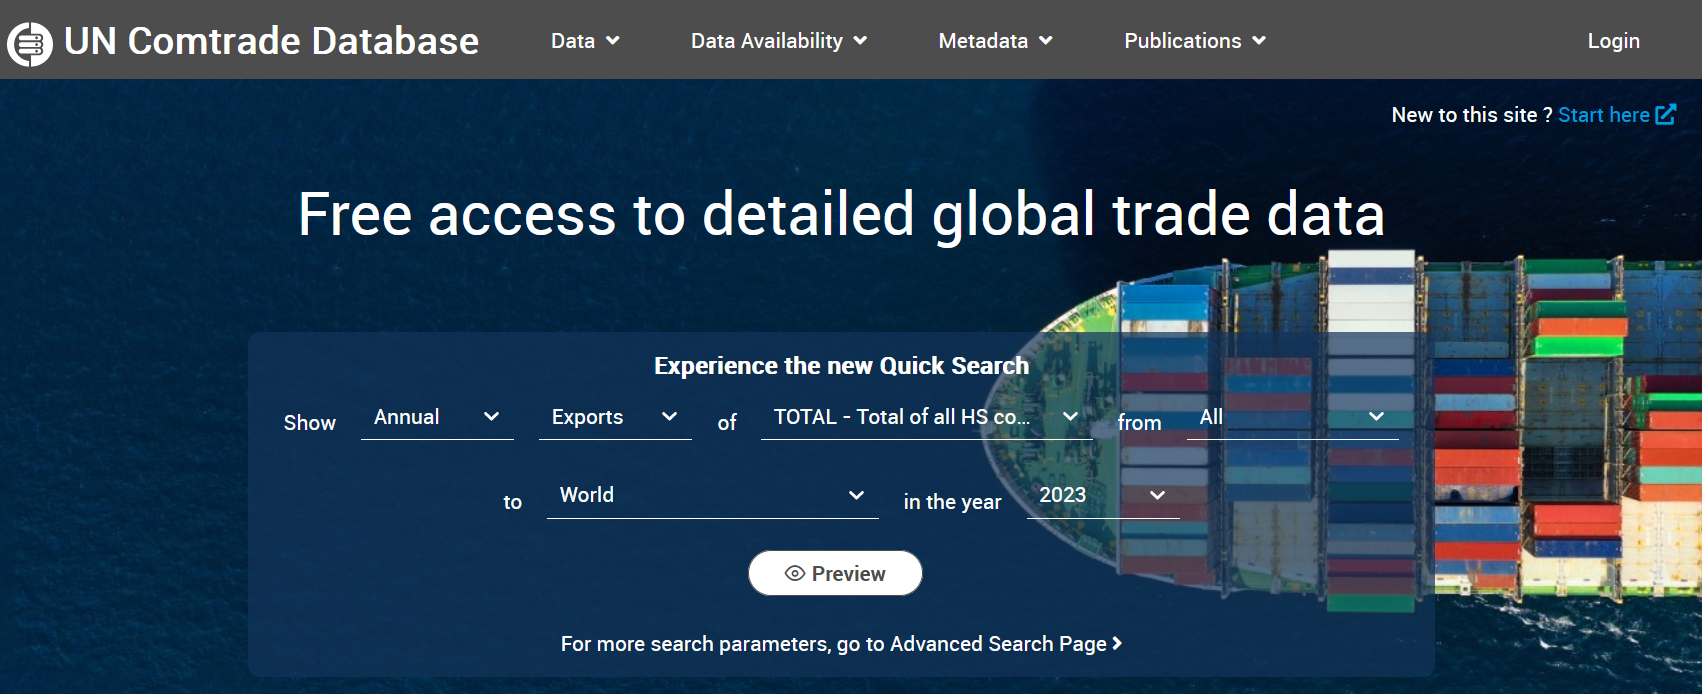

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 

FILE = './imgs/comtrade-2024-land.png'

Image(filename=FILE)

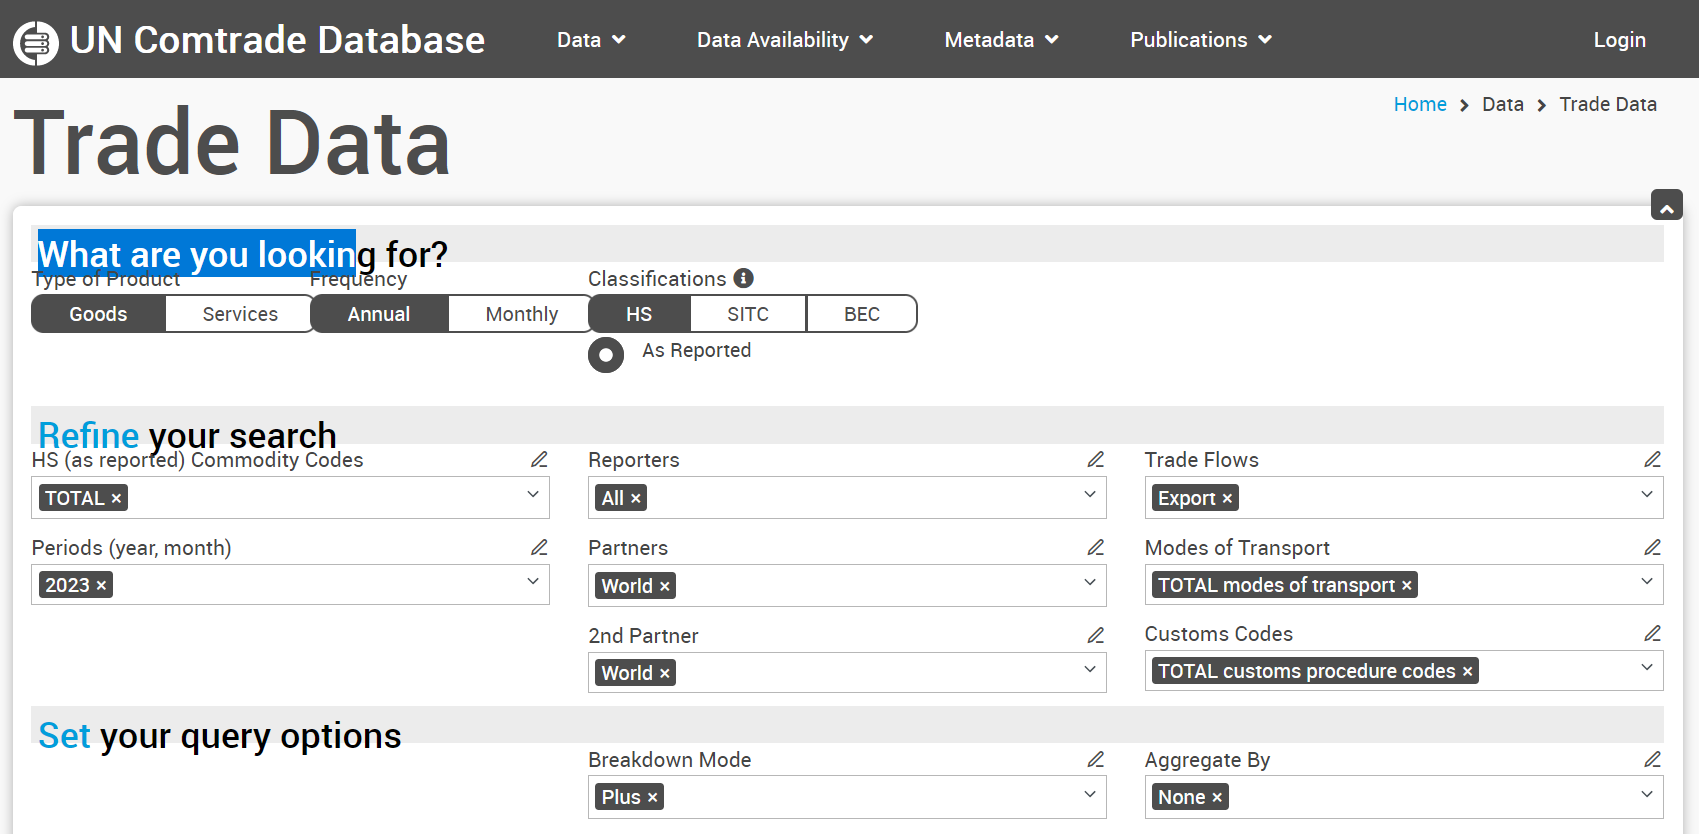

In [2]:
FILE2 = './imgs/comtrade-2024-search.png'

Image(filename=FILE2)

#### From the class repo all CSV files for 2003 can be obtained through the link 'Direct Download'

#### Here is the data files downloaded (the aggregate and the products category used for the examples in the book)

In [ ]:
# uncomment for lin/colab execution:
# %ls data\comtrade_trade*

# uncomment for win execution
# !dir data\comtrade_trade*

### Check the data file

In [ ]:
# lin/colab only command!
# %head data/comtrade_trade_data_2003_product_09.csv

### Special 'Country codess' to be exluded when loading data

* 472	Africa CAMEU region, nes
* 899	Areas, nes
* 471	CACM, nes
* 129	Caribbean, nes
* 221	Eastern Europe, nes
* 97	 EU-27
* 697	Europe EFTA, nes
* 492	Europe EU, nes
* 838	Free Zones
* 473	LAIA, nes
* 536	Neutral Zone
* 637	North America and Central America, nes
* 290	Northern Africa, nes
* 527	Oceania, nes
* 577	Other Africa, nes
* 490	Other Asia, nes
* 568	Other Europe, nes
* 636	Rest of America, nes
* 839	Special Categories
* 879	Western Asia, nes
* 0      World


## Network Symmetrisation

In [3]:
# Importing packages
import networkx as nx
import numpy as np

In [4]:
def net_symmetrisation(input_file, exclude_countries):
    
    DG = nx.DiGraph()

    # Column Indexes
    Reporter_pos = 1
    Partner_pos = 3
    Flow_code_pos = 2
    Value_pos = 9

    # Parse file and create directed graph
    dic_trade_flows = {}
    hfile = open(input_file,'r')

    header = hfile.readline()
    lines = hfile.readlines()

    for l in lines:
        l_split = l.split(',')

        # the following is to prevent parsing lines without data
        if len(l_split) < 2:
            continue

        reporter = int(l_split[Reporter_pos])
        partner = int(l_split[Partner_pos])
        flow_code = int(l_split[Flow_code_pos])
        value = float(l_split[Value_pos])

        if any([
            reporter in exclude_countries,
            partner in exclude_countries,
            reporter == partner
            ]):
            continue

        # Flow code = 1: Import | Flow code = 1: Export
        # Aggregation: export i -> j is not equal to import j -> i
        # Therefore: Export ij = (Export ij + Import ji) / 2
        if flow_code == 1 and value > 0.0:
            if (partner, reporter, 2) in dic_trade_flows:
                DG[partner][reporter]['weight'] = \
                 (DG[partner][reporter]['weight'] + value) / 2.0

            else:
                DG.add_edge(partner, reporter, weight=value)

                # This is to mark the existence of the link
                dic_trade_flows[(partner, reporter, 1)] = value

        elif flow_code == 2 and value > 0.0:
            if  (reporter, partner, 1) in dic_trade_flows:
                DG[reporter][partner]['weight'] = \
                 (DG[reporter][partner]['weight'] + value) / 2.0

            else:
                DG.add_edge(reporter, partner, weight=value)

                # This is to mark the existence of the link
                dic_trade_flows[(reporter, partner, 2)] = value
        else:
            print ("trade flow not present\n")

    hfile.close()

    return DG

## Generate the aggregate network
### Q1. Generate an undirected  trade network for UK using country code: 826

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
number of nodes 232
number of edges 27901


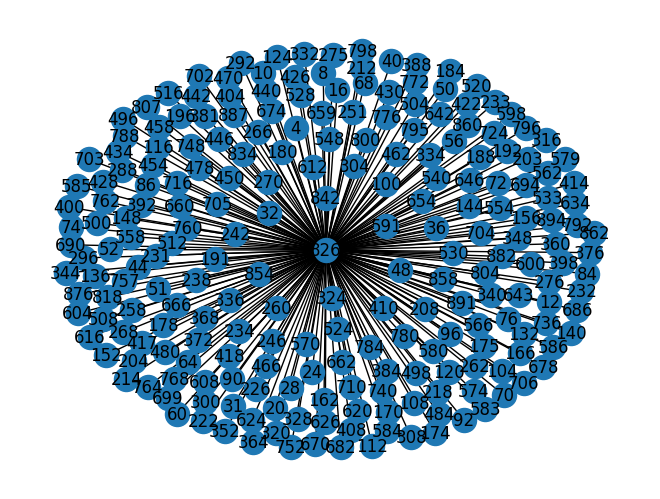

In [5]:
# Countries to be excluded
exclude_countries = [
    472, 899, 471, 129, 221, 97, 697, 492, 838, 473,
    536, 637, 290, 527, 577, 490, 568, 636, 839, 879, 0
    ]

# This is the magic command to have the graphic embedded
# in the notebook
%pylab inline

total_data_csv = "data/comtrade_trade_data_total_2003.csv"
DG = net_symmetrisation(total_data_csv, exclude_countries)

print("number of nodes", DG.number_of_nodes())
print("number of edges", DG.number_of_edges())

# Create graph for the UK - UK country code is 826
c_code = 826
B = nx.Graph()
B.add_nodes_from([c_code])

# Create edges and add them
edges = [(c_code, key) for key in DG.__getitem__(c_code)]
B.add_edges_from(edges)
nx.draw(B, with_labels=True)

## Reciprocity

We can define both the reciprocity in the unweighted case as:
$$r=\frac{L^\leftrightarrow}{L}$$
where $${L^\leftrightarrow}$$ is the number of reciprocated links that for a connected network ammounts to $$2L-N(N-1)$$


In [6]:
# Unweighted case
N = DG.number_of_nodes()
L = DG.number_of_edges()

r = float((2*L - N*(N - 1))) / L
print(r)

0.07920863051503531


In the weighted case the formula changes in:

$$r=\frac{W^\leftrightarrow}{W}$$

where 

$$W^\leftrightarrow=\sum_i\sum_{j\neq i}w^\leftrightarrow_{ij}$$ 

is the sum of the reciprocated weights with 

$$w^\leftrightarrow_{ij}=min[w_{ij},w_{ji}]=w^\leftrightarrow_{ji}$$

and $$W=\sum_i\sum_{j\neq i}w_{ij}.$$

In [7]:
# Weighted case
W = 0
W_rep = 0

for n in DG.nodes():
    for e in DG.out_edges(n, data=True):
        W += e[2]['weight']
        if DG.has_edge(e[1], e[0]):
            W_rep += min(DG[e[0]][e[1]]['weight'], DG[e[1]][e[0]]['weight'])

print (W, W_rep, W_rep / W)

7177664759252.5 5196276060567.0 0.723950788293455


(array([26., 18., 22., 33., 31., 33., 33., 21., 11.,  2.,  1.,  1.]),
 array([244.2079646 , 259.44063422, 274.67330383, 289.90597345,
        305.13864307, 320.37131268, 335.6039823 , 350.83665192,
        366.06932153, 381.30199115, 396.53466077, 411.76733038,
        427.        ]),
 <BarContainer object of 12 artists>)

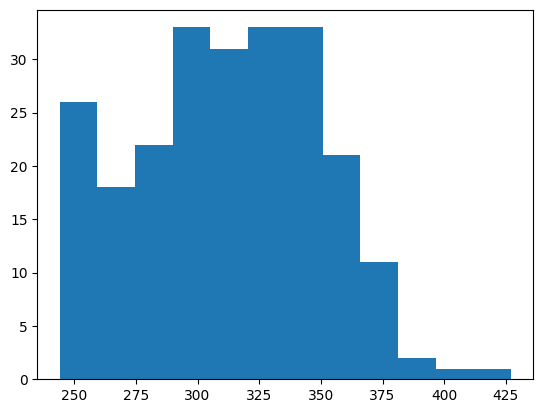

In [8]:
# Assortativity with neighbor nodes degree
list_knn = []

for n in DG.nodes():
    degree = 0

    for nn in DG.neighbors(n):
        degree += DG.degree(nn)
    list_knn.append(degree / len(list(DG.neighbors(n))))

# plot the histogram
hist(list_knn, bins=12)

In [ ]:
# Basic Pearson correlation coefficient for the graph
r = nx.degree_assortativity_coefficient(DG)
print(r)

### To compute the weighted version of the assortativity Networkx has extra parameters and also the possibility to decide for 'out' or 'in' degree correlations both for the source and target nodes (the default is x='out', y='in')

In [ ]:
# Weighted version
r = nx.degree_pearson_correlation_coefficient(
    DG, weight='weight', x='out', y='out'
    )

print(r)

## Density and Strength (in and out)

### Load Product Networks

In [ ]:
dic_product_networks = {}
commodity_codes = [
    '09','10','27','29','30','39','52','71','72','84', '85','87','90','93'
    ]

for c in commodity_codes:
    csv_file = "data/comtrade_trade_data_2003_product_" + c + ".csv"
    dic_product_networks[c] = net_symmetrisation(csv_file, exclude_countries)

total_data_csv_path = "data/comtrade_trade_data_total_2003.csv"
DG_aggregate = net_symmetrisation(total_data_csv_path, exclude_countries)

### Rescale the weighted ajacency aggregate matrix
$$w_{ij}^{tot}=\frac{ w_{ij}^{tot} }{ \sum_{hk}w_{hk}^{tot} }$$

In [ ]:
# Rescale the weights
w_tot = 0.0
for u, v, d  in DG_aggregate.edges(data=True):
    w_tot += d['weight']

for u, v, d in DG_aggregate.edges(data=True):
    d['weight'] = d['weight'] / w_tot

### Rescale the weighted ajacency product matrices
$$w_{ij}^c=\frac{w_{ij}^c}{\sum_{hk}w_{hk}^c}$$

In [ ]:
# Rescale the weights for the products
for c in commodity_codes:
    l_p = []
    w_tot = 0.0

    for u, v, d in dic_product_networks[c].edges(data=True):
        w_tot += d['weight']

    for u,v,d in dic_product_networks[c].edges(data=True):
        d['weight'] = d['weight'] / w_tot

### Generate the table with the quantities
$$Density\   w_{ij}\  NS_{in}/ND_{in}\  NS_{out}/ND_{out}$$

In [ ]:
aggr_n_edges = DG_aggregate.number_of_edges()
aggr_n_nodes = DG_aggregate.number_of_nodes()
density_aggregate = aggr_n_edges / (aggr_n_nodes * (aggr_n_nodes - 1.0))

w_agg = []
NS_in = []
NS_out = []

for u, v, d in DG_aggregate.edges(data=True):
    w_agg.append(d['weight'])

for n in DG_aggregate.nodes():
    if DG_aggregate.in_degree(n) > 0:

        incoming_weight_sum = DG_aggregate.in_degree(n, weight='weight')
        incoming_degree = DG_aggregate.in_degree(n)

        NS_in.append(incoming_weight_sum / incoming_degree)

    if DG_aggregate.out_degree(n) > 0:

        outcoming_weight_sum = DG_aggregate.out_degree(n, weight='weight')
        outcoming_degree = DG_aggregate.out_degree(n)

        NS_out.append(outcoming_weight_sum / outcoming_degree)

for c in commodity_codes:
    n_edges = dic_product_networks[c].number_of_edges()
    n_nodes = dic_product_networks[c].number_of_nodes()

    density_commodity = n_edges / (n_nodes * (n_nodes - 1.0))

    w_c = []
    NS_c_in = []
    NS_c_out = []

    for u, v, d  in dic_product_networks[c].edges(data=True):
        w_c.append(d['weight'])

    for n in dic_product_networks[c].nodes():
        if dic_product_networks[c].in_degree(n) > 0:

            incoming_weight_sum = dic_product_networks[c].in_degree(n, weight='weight')
            incoming_degree = dic_product_networks[c].in_degree(n)

            NS_c_in.append(incoming_weight_sum / incoming_degree)

        if dic_product_networks[c].out_degree(n) > 0:

            outcoming_weight_sum = dic_product_networks[c].out_degree(n, weight='weight')
            outcoming_degree = dic_product_networks[c].out_degree(n)

            NS_c_out.append(outcoming_weight_sum / outcoming_degree)

    print(c, str(round(density_commodity / density_aggregate, 4)) + " & " + \
          str(round(np.mean(w_c) / np.mean(w_agg), 4)) + " & " + \
          str(round(np.mean(NS_c_in) / np.mean(NS_in), 4)) + " & " + \
          str(round(np.mean(NS_c_out) / np.mean(NS_out), 4)))


## Revealed Comparative Advantage

In [ ]:
def RCA(c, p):
    """
    :param c: Integer, country
    :param p: String, product

    :return RCA_cp: Float, Revealed Comparative Advantage for
    country c, product p
    """
    # Country c product p export value
    X_cp = dic_product_networks[p].out_degree(c, weight='weight')

    # Country total export value
    X_c = DG_aggregate.out_degree(c, weight='weight')

    # Total product p export value
    X_p = 0.0
    for n in dic_product_networks[p].nodes():
        X_p += dic_product_networks[p].out_degree(n, weight='weight')

    # Total exports
    X_tot = 0.0
    for n in DG_aggregate.nodes():
        X_tot += DG_aggregate.out_degree(n, weight='weight')

    RCA_cp = (X_cp / X_c) / (X_p / X_tot)
    return RCA_cp

p = '93'
c = 381
print(RCA(c, p))

## Bipartite Network

### Define the country-product matrix

In [ ]:
num_countries = DG_aggregate.number_of_nodes()
num_products = len(commodity_codes)

# Generate array indices
country_index = {}
i = 0

for c in DG_aggregate.nodes():
    country_index[c] = i
    i += 1

M = np.zeros((num_countries, num_products))

for pos_p, p in enumerate(commodity_codes):
    for c in dic_product_networks[p].nodes():

        if RCA(c, p) > 1.0:
            M[country_index[c]][pos_p] = 1.0

    print("\r")

C = np.dot(M, M.transpose())
P = np.dot(M.transpose(), M)

print(C)
print(P)